In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
import numpy as np
import json

np.set_printoptions(precision=3, suppress=True)
# uncomment and replace with correct path if there are import errors
# sys.path.append("/path/to/surface-sampling/")
# sys.path.append("/path/to/NeuralForceField/")
# os.environ["LAMMPS_POTENTIALS"] = "/path/to/lammps/potentials/"
# os.environ["LAMMPS_COMMAND"] ="/path/to/lammps/src/lmp_serial"
# os.environ["ASE_LAMMPSRUN_COMMAND"] = os.environ["LAMMPS_COMMAND"]

from mcmc import MCMC
from mcmc.system import SurfaceSystem
from mcmc.utils.misc import get_atoms_batch

from time import perf_counter

/home/dux/NeuralForceField/models


Initialize test slab and parameters

In [3]:
# Load prepared pristine slab
element = []
slab_pkl = open("data/SrTiO3_001_2x2_pristine_slab.pkl", "rb")
slab = pickle.load(slab_pkl)
offset_data_path = os.path.join(
    os.getcwd(),
    "data/nff",
    "offset_data.json",
)

system_settings = {
    "surface_name": "SrTiO3(001)",
    "cutoff": 5.0,
    "near_reduce": 0.01,
    "planar_distance": 1.55,
    "no_obtuse_hollow": True,
}

sampling_settings = {
    "alpha": 1.0,  # no annealing
    "temperature": 1.0,  # in terms of kbT
    "num_sweeps": 10,
    "sweep_size": 5,
}

calc_settings = {
    "calc_name": "NFF",
    "optimizer": "BFGS",
    "chem_pots": {"Sr": -2, "Ti": 0, "O": 0},
    "relax_atoms": True,
    "relax_steps": 20,
    "offset": True,
    "offset_data": json.load(open(offset_data_path, "r")),
}

Obtain adsorption sites

In [4]:
from pymatgen.analysis.adsorption import AdsorbateSiteFinder
from pymatgen.io.ase import AseAtomsAdaptor

pristine_slab = slab.copy()
pristine_pmg_slab = AseAtomsAdaptor.get_structure(pristine_slab)
site_finder = AdsorbateSiteFinder(pristine_pmg_slab)

ads_positions = site_finder.find_adsorption_sites(
    put_inside=True,
    symm_reduce=False,
    near_reduce=system_settings["near_reduce"],
    distance=system_settings["planar_distance"],
    no_obtuse_hollow=system_settings["no_obtuse_hollow"],
)["all"]

print(f"adsorption coordinates are: {ads_positions[:5]}...")

adsorption coordinates are: [array([ 7.871,  7.941, 18.87 ]), array([ 1.968,  1.951, 18.829]), array([ 1.968,  0.146, 18.782]), array([ 7.871,  3.956, 18.87 ]), array([ 1.968,  5.936, 18.829])]...


Set up NFF (calculator). We are using neural network weights from our Zenodo dataset (https://zenodo.org/record/7927039). The ensemble requires an `offset_data.json` file

In [5]:
import torch
from nff.io.ase_calcs import NeuralFF
from nff.utils.cuda import cuda_devices_sorted_by_free_mem
from mcmc.calculators import EnsembleNFFSurface

if torch.cuda.is_available():
    DEVICE = f"cuda:{cuda_devices_sorted_by_free_mem()[-1]}"
else:
    DEVICE = "cpu"

# requires an ensemble of models in this path and an `offset_data.json` file
nnids = ["model01", "model02", "model03"]
model_dirs = [
    os.path.join(
        os.getcwd(),
        "data/nff",
        str(x),
        "best_model",
    )
    for x in nnids
]

models = []
for modeldir in model_dirs:
    m = NeuralFF.from_file(modeldir, device=DEVICE).model
    models.append(m)

nff_surf_calc = EnsembleNFFSurface(models, device=DEVICE)
nff_surf_calc.set(**calc_settings)

offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters
chemical potentials: {'Sr': -2, 'Ti': 0, 'O': 0} are set from parameters
offset data: {'bulk_energies': {'O': -0.17747231201, 'Sr': -0.06043637668, 'SrTiO3': -1.470008697358702}, 'stoidict': {'Sr': 0.49995161381315867, 'Ti': -0.0637500349111578, 'O': -0.31241304903276834, 'offset': -11.324476454433157}, 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3}, 'ref_formula': 'SrTiO3', 'ref_element': 'Ti'} is set from parameters


Initialize surface system

In [6]:
slab_batch = get_atoms_batch(
    slab,
    system_settings["cutoff"],
    DEVICE,
    props={"energy": 0, "energy_grad": []},
)

surface = SurfaceSystem(
    slab_batch,
    ads_positions,
    calc=nff_surf_calc,
    surface_depth=1,
    system_settings=system_settings,
)
surface.all_atoms.write("SrTiO3_001_2x2_all_virtual_ads.cif")

2024-06-28 10:48:56,799|INFO|initializing 64 virtual atoms
2024-06-28 10:48:56,841|INFO|initial state is [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
2024-06-28 10:48:56,842|INFO|number of pristine atoms is 60
2024-06-28 10:48:56,850|INFO|bulk indices are [ 0  1  2  3  4  5  6  9 10 11 12 13 14 15 16 17 18 19 20 21 24 25 26 27
 28 29 30 31 32 33 34 35 36 39 40 41 42 43 44 45 46 47 48 49 50 51 54 55
 56 57 58 59]
2024-06-28 10:48:56,851|INFO|surface indices are [ 7  8 22 23 37 38 52 53]


      Step     Time          Energy         fmax
BFGS:    0 10:48:57     -467.521881        0.2044
BFGS:    1 10:48:57     -467.525757        0.1803
BFGS:    2 10:48:57     -467.540619        0.0793
BFGS:    3 10:48:57     -467.540924        0.0598
BFGS:    4 10:48:57     -467.541351        0.0059


In [7]:
surface.get_potential_energy()

array([-467.541], dtype=float32)

In [8]:
surface.calc.offset_data

{'bulk_energies': {'O': -0.17747231201,
  'Sr': -0.06043637668,
  'SrTiO3': -1.470008697358702},
 'stoidict': {'Sr': 0.49995161381315867,
  'Ti': -0.0637500349111578,
  'O': -0.31241304903276834,
  'offset': -11.324476454433157},
 'stoics': {'Sr': 1, 'Ti': 1, 'O': 3},
 'ref_formula': 'SrTiO3',
 'ref_element': 'Ti'}

In [9]:
surface.get_surface_energy()

array([12.471], dtype=float32)

Perform MCMC and view results. Detailed results can be found in the corresponding run in the `SrTiO3(001)/` folder.

2024-06-28 10:48:58,088|INFO|there are 60 atoms in pristine slab
2024-06-28 10:48:58,092|INFO|Running with num_sweeps = 10, temp = 1.0, pot = [-2, 0, 0], alpha = 1.0
2024-06-28 10:48:58,093|INFO|In pristine slab, there are a total of 64 sites


      Step     Time          Energy         fmax
BFGS:    0 10:48:58     -467.521881        0.2044
BFGS:    1 10:48:58     -467.525757        0.1803
BFGS:    2 10:48:58     -467.540619        0.0793
BFGS:    3 10:48:58     -467.540924        0.0598
BFGS:    4 10:48:58     -467.541351        0.0059


2024-06-28 10:48:58,663|INFO|running for 5 iterations per run over a total of 10 runs
2024-06-28 10:48:58,665|INFO|starting with iteration 0
2024-06-28 10:48:58,667|INFO|In sweep 1 out of 10


temp list is:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
      Step     Time          Energy         fmax
BFGS:    0 10:48:58     -461.974609       35.5128
BFGS:    1 10:48:58     -467.614594        6.9389
BFGS:    2 10:48:58     -468.047363        4.6872
BFGS:    3 10:48:59     -468.577545        1.8680
BFGS:    4 10:48:59     -468.817719        0.9238
BFGS:    5 10:48:59     -468.917816        1.0654
BFGS:    6 10:48:59     -468.946014        1.1250
BFGS:    7 10:48:59     -468.997711        1.0693
BFGS:    8 10:48:59     -469.102631        0.4876
BFGS:    9 10:48:59     -469.120026        0.3527
BFGS:   10 10:48:59     -469.138275        0.3299
BFGS:   11 10:48:59     -469.144379        0.2242
BFGS:   12 10:48:59     -469.153961        0.2656
BFGS:   13 10:48:59     -469.162750        0.2988
BFGS:   14 10:48:59     -469.170807        0.2347
BFGS:   15 10:49:00     -469.175690        0.1974
BFGS:   16 10:49:00     -469.178070        0.1673
BFGS:   17 10:49:00     -469.180176        0.1311
BFGS:

2024-06-28 10:49:09,071|INFO|current energy is [12.471], calculated energy is 12.4705810546875
2024-06-28 10:49:09,072|INFO|optim structure has Energy = 12.471+/-0.312
2024-06-28 10:49:09,072|INFO|average force error = 0.028
2024-06-28 10:49:09,079|INFO|In sweep 2 out of 10


      Step     Time          Energy         fmax
BFGS:    0 10:49:09     -461.974609       35.5128
BFGS:    1 10:49:09     -467.614594        6.9389
BFGS:    2 10:49:09     -468.047363        4.6872
BFGS:    3 10:49:09     -468.577606        1.8680
BFGS:    4 10:49:09     -468.817657        0.9238
BFGS:    5 10:49:09     -468.917816        1.0654
BFGS:    6 10:49:09     -468.946014        1.1250
BFGS:    7 10:49:09     -468.997711        1.0693
BFGS:    8 10:49:10     -469.102570        0.4876
BFGS:    9 10:49:10     -469.120026        0.3527
BFGS:   10 10:49:10     -469.138275        0.3299
BFGS:   11 10:49:10     -469.144379        0.2242
BFGS:   12 10:49:10     -469.153961        0.2656
BFGS:   13 10:49:10     -469.162750        0.2988
BFGS:   14 10:49:10     -469.170807        0.2348
BFGS:   15 10:49:10     -469.175659        0.1975
BFGS:   16 10:49:11     -469.178070        0.1673
BFGS:   17 10:49:11     -469.180176        0.1311
BFGS:   18 10:49:11     -469.183441        0.1513
B

2024-06-28 10:49:23,775|INFO|current energy is [13.191], calculated energy is 13.191314697265625
2024-06-28 10:49:23,776|INFO|optim structure has Energy = 13.191+/-0.161
2024-06-28 10:49:23,776|INFO|average force error = 0.037
2024-06-28 10:49:23,784|INFO|In sweep 3 out of 10


      Step     Time          Energy         fmax
BFGS:    0 10:49:23     -473.567383        6.3134
BFGS:    1 10:49:24     -474.289337        4.3500
BFGS:    2 10:49:24     -475.321075        2.9903
BFGS:    3 10:49:24     -475.992401        1.9445
BFGS:    4 10:49:24     -476.325928        1.7748
BFGS:    5 10:49:24     -476.513336        1.7717
BFGS:    6 10:49:24     -476.986481        1.2992
BFGS:    7 10:49:24     -477.074615        1.0423
BFGS:    8 10:49:24     -477.310181        0.8870
BFGS:    9 10:49:24     -477.416260        1.1141
BFGS:   10 10:49:24     -477.526581        1.2918
BFGS:   11 10:49:24     -477.614166        1.0080
BFGS:   12 10:49:25     -477.671417        0.5650
BFGS:   13 10:49:25     -477.696869        0.3872
BFGS:   14 10:49:25     -477.713867        0.3891
BFGS:   15 10:49:25     -477.728363        0.4116
BFGS:   16 10:49:25     -477.740479        0.2925
BFGS:   17 10:49:25     -477.747650        0.3156
BFGS:   18 10:49:25     -477.752716        0.2798
B

2024-06-28 10:49:36,149|INFO|current energy is [8.62], calculated energy is 8.620086669921875
2024-06-28 10:49:36,149|INFO|optim structure has Energy = 8.620+/-0.025
2024-06-28 10:49:36,150|INFO|average force error = 0.051
2024-06-28 10:49:36,157|INFO|In sweep 4 out of 10


      Step     Time          Energy         fmax
BFGS:    0 10:49:36     -481.998871        7.6038
BFGS:    1 10:49:36     -484.183502        4.2163
BFGS:    2 10:49:36     -486.389374        3.8903
BFGS:    3 10:49:36     -487.452637        3.2275
BFGS:    4 10:49:36     -488.297272        3.2106
BFGS:    5 10:49:36     -488.850830        2.7651
BFGS:    6 10:49:36     -489.303436        2.1233
BFGS:    7 10:49:37     -490.003174        1.9850
BFGS:    8 10:49:37     -490.167450        1.9160
BFGS:    9 10:49:37     -490.436615        1.0327
BFGS:   10 10:49:37     -490.652435        1.1040
BFGS:   11 10:49:37     -490.628326        1.7256
BFGS:   12 10:49:37     -490.853607        1.1898
BFGS:   13 10:49:37     -490.936157        0.8358
BFGS:   14 10:49:37     -491.087494        0.5203
BFGS:   15 10:49:37     -491.110474        0.5017
BFGS:   16 10:49:37     -491.218475        0.7068
BFGS:   17 10:49:37     -491.255859        0.6232
BFGS:   18 10:49:38     -491.320831        0.5543
B

2024-06-28 10:49:48,548|INFO|current energy is [8.666], calculated energy is 8.66650390625
2024-06-28 10:49:48,548|INFO|optim structure has Energy = 8.667+/-0.329
2024-06-28 10:49:48,549|INFO|average force error = 0.066
2024-06-28 10:49:48,556|INFO|In sweep 5 out of 10


      Step     Time          Energy         fmax
BFGS:    0 10:49:48     -406.852783      464.0161
BFGS:    1 10:49:48     -375.420532       87.4717
BFGS:    2 10:49:48     -390.675781      100.6709
BFGS:    3 10:49:48     -411.731689      151.1577
BFGS:    4 10:49:49     -433.130615      126.6118
BFGS:    5 10:49:49     -453.177338       67.5321
BFGS:    6 10:49:49     -463.863434       32.2332
BFGS:    7 10:49:49     -469.625519       17.5515
BFGS:    8 10:49:49     -473.176270       10.6883
BFGS:    9 10:49:49     -475.240570        5.9840
BFGS:   10 10:49:49     -476.526001        4.9317
BFGS:   11 10:49:49     -477.435791        5.2811
BFGS:   12 10:49:49     -478.161987        6.0262
BFGS:   13 10:49:49     -479.317291        4.7562
BFGS:   14 10:49:49     -479.947754        2.8241
BFGS:   15 10:49:50     -480.371735        2.5557
BFGS:   16 10:49:50     -480.827118        2.6831
BFGS:   17 10:49:50     -481.479340        2.5046
BFGS:   18 10:49:50     -481.995972        2.4581
B

2024-06-28 10:50:00,939|INFO|current energy is [6.763], calculated energy is 14.861328125
2024-06-28 10:50:00,939|INFO|optim structure has Energy = 14.861+/-41.163
2024-06-28 10:50:00,940|INFO|average force error = 3.135
2024-06-28 10:50:00,945|INFO|In sweep 6 out of 10


      Step     Time          Energy         fmax
BFGS:    0 10:50:01     -358.541016      266.1869
BFGS:    1 10:50:01      617.250916    18141.8341
BFGS:    2 10:50:01      118.096497     9146.5924
BFGS:    3 10:50:01     -315.347046     1687.1766
BFGS:    4 10:50:01     -382.281891     1107.9911
BFGS:    5 10:50:01     -442.205322      322.7905
BFGS:    6 10:50:01     -437.019318      294.5921
BFGS:    7 10:50:01     -459.700653       20.4722
BFGS:    8 10:50:01     -463.289276       34.4884
BFGS:    9 10:50:01     -467.757599       33.4539
BFGS:   10 10:50:02     -469.954742       37.6130
BFGS:   11 10:50:02     -470.974121       14.8002
BFGS:   12 10:50:02     -472.209839       57.3594
BFGS:   13 10:50:02     -473.043701       19.7922
BFGS:   14 10:50:02     -473.827026       13.5183
BFGS:   15 10:50:02     -474.073578        9.9196
BFGS:   16 10:50:02     -474.325043       13.7001
BFGS:   17 10:50:02     -474.607574        5.8628
BFGS:   18 10:50:02     -474.716064        2.1024
B

2024-06-28 10:50:13,862|INFO|current energy is [12.979], calculated energy is 14.41748046875
2024-06-28 10:50:13,862|INFO|optim structure has Energy = 14.417+/-43.186
2024-06-28 10:50:13,863|INFO|average force error = 4.305
2024-06-28 10:50:13,871|INFO|In sweep 7 out of 10


      Step     Time          Energy         fmax
BFGS:    0 10:50:14     1211.411499    29724.1634
BFGS:    1 10:50:14     -416.067719      177.7089
BFGS:    2 10:50:14      620.815186    18661.0799
BFGS:    3 10:50:14     -114.356941     5360.4119
BFGS:    4 10:50:14     -397.416901      741.2474
BFGS:    5 10:50:14     -428.097015      344.5258
BFGS:    6 10:50:14     -444.023682      108.8171
BFGS:    7 10:50:14     -437.964355      311.1183
BFGS:    8 10:50:15     -434.766815      185.6965
BFGS:    9 10:50:15     -448.852020       75.0872
BFGS:   10 10:50:15     -451.259369       67.5227
BFGS:   11 10:50:15     -453.916870       46.8157
BFGS:   12 10:50:15     -455.444550       35.9628
BFGS:   13 10:50:15     -456.129364       68.6277
BFGS:   14 10:50:15     -457.384918       53.5117
BFGS:   15 10:50:15     -458.694580       39.0610
BFGS:   16 10:50:15     -459.199615       61.7125
BFGS:   17 10:50:16     -459.416901       67.2197
BFGS:   18 10:50:16     -459.936676       49.3181
B

2024-06-28 10:50:28,929|INFO|current energy is [12.869], calculated energy is 13.535064697265625
2024-06-28 10:50:28,930|INFO|optim structure has Energy = 13.535+/-46.304
2024-06-28 10:50:28,931|INFO|average force error = 5.365
2024-06-28 10:50:28,942|INFO|In sweep 8 out of 10


      Step     Time          Energy         fmax
BFGS:    0 10:50:29     -441.444794      157.1712
BFGS:    1 10:50:29      442.792755    15790.9219
BFGS:    2 10:50:29     -174.624100     4735.5236
BFGS:    3 10:50:29     -424.083466      715.2817
BFGS:    4 10:50:29     -451.695557      295.3251
BFGS:    5 10:50:29     -467.117279       36.3173
BFGS:    6 10:50:29     -469.451630      107.2897
BFGS:    7 10:50:29     -473.948395       71.1505
BFGS:    8 10:50:29     -477.583099       86.4644
BFGS:    9 10:50:29     -475.393311      291.9794
BFGS:   10 10:50:29     -479.061249       45.5167
BFGS:   11 10:50:30     -479.938446       41.9955
BFGS:   12 10:50:30     -481.921783       73.7845
BFGS:   13 10:50:30     -483.068756      143.2625
BFGS:   14 10:50:30     -484.331299       58.0309
BFGS:   15 10:50:30     -486.090088      101.3375
BFGS:   16 10:50:30     -485.753082      197.2256
BFGS:   17 10:50:30     -488.455658       99.3685
BFGS:   18 10:50:30     -490.239166       36.8515
B

2024-06-28 10:50:42,268|INFO|current energy is [8.529], calculated energy is 8.52886962890625
2024-06-28 10:50:42,269|INFO|optim structure has Energy = 8.529+/-0.166
2024-06-28 10:50:42,270|INFO|average force error = 0.076
2024-06-28 10:50:42,282|INFO|In sweep 9 out of 10


      Step     Time          Energy         fmax
BFGS:    0 10:50:42     -469.742188       25.9230
BFGS:    1 10:50:42     -479.071381       12.4613
BFGS:    2 10:50:42     -484.954498        7.3941
BFGS:    3 10:50:42     -488.881714        5.3412
BFGS:    4 10:50:42     -491.209259        3.5312
BFGS:    5 10:50:42     -492.741211        2.5493
BFGS:    6 10:50:42     -493.538330        2.1037
BFGS:    7 10:50:43     -494.049530        2.4878
BFGS:    8 10:50:43     -495.497406        2.8751
BFGS:    9 10:50:43     -496.436249        2.1968
BFGS:   10 10:50:43     -496.828735        1.8906
BFGS:   11 10:50:43     -497.111115        1.5555
BFGS:   12 10:50:43     -497.397461        1.2706
BFGS:   13 10:50:43     -497.674774        1.1922
BFGS:   14 10:50:43     -497.858734        1.0918
BFGS:   15 10:50:43     -498.028900        1.1343
BFGS:   16 10:50:43     -498.179718        1.0053
BFGS:   17 10:50:43     -498.302887        0.8307
BFGS:   18 10:50:43     -498.400482        0.8279
B

2024-06-28 10:50:55,235|INFO|current energy is [1.17], calculated energy is 1.17022705078125
2024-06-28 10:50:55,236|INFO|optim structure has Energy = 1.170+/-0.070
2024-06-28 10:50:55,236|INFO|average force error = 0.079
2024-06-28 10:50:55,243|INFO|In sweep 10 out of 10


      Step     Time          Energy         fmax
BFGS:    0 10:50:55     -443.947021      189.6866
BFGS:    1 10:50:55      344.435699    13998.4056
BFGS:    2 10:50:55     -257.054962     3408.6978
BFGS:    3 10:50:55     -433.495361      656.5486
BFGS:    4 10:50:55     -469.541290      152.3817
BFGS:    5 10:50:55     -479.978638       43.2421
BFGS:    6 10:50:55     -484.752289       78.2104
BFGS:    7 10:50:56     -488.253296       18.4494
BFGS:    8 10:50:56     -490.141113       14.5401
BFGS:    9 10:50:56     -491.749268       18.9201
BFGS:   10 10:50:56     -493.069427       27.1497
BFGS:   11 10:50:56     -494.045746       21.6215
BFGS:   12 10:50:56     -495.581818       29.1702
BFGS:   13 10:50:56     -496.383911       20.5270
BFGS:   14 10:50:56     -497.034546       28.8575
BFGS:   15 10:50:56     -498.256989       44.7925
BFGS:   16 10:50:56     -499.254395       23.1650
BFGS:   17 10:50:56     -499.932709       22.7662
BFGS:   18 10:50:57     -500.355072       34.5963
B

2024-06-28 10:51:08,377|INFO|current energy is [1.17], calculated energy is 1.17022705078125
2024-06-28 10:51:08,378|INFO|optim structure has Energy = 1.170+/-0.070
2024-06-28 10:51:08,379|INFO|average force error = 0.079


Time taken = 130.61290565691888 seconds


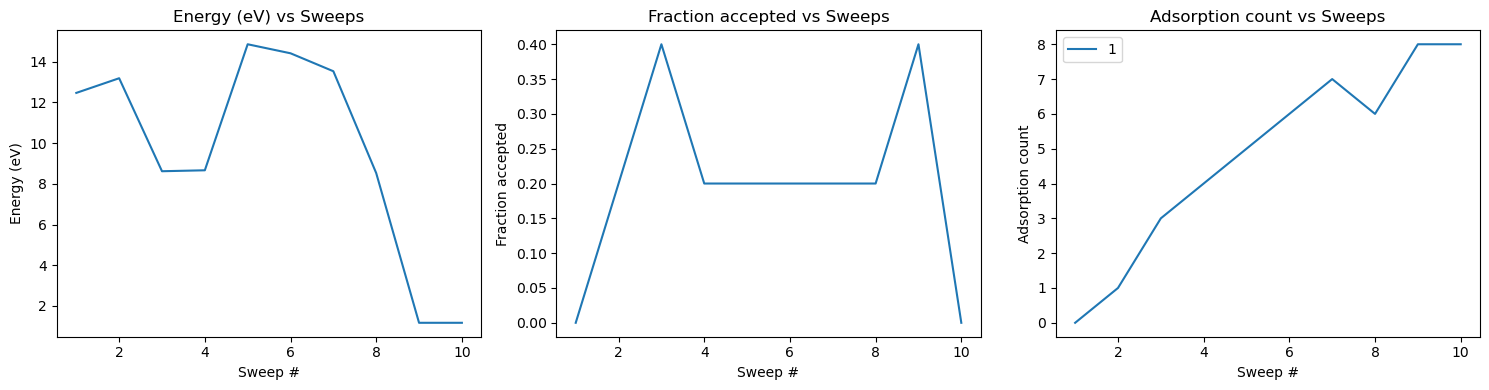

In [10]:
mcmc = MCMC(
    system_settings["surface_name"],
    calc=nff_surf_calc,
    canonical=False,
    testing=False,
    element=element,
    adsorbates=list(calc_settings["chem_pots"].keys()),
    relax=calc_settings["relax_atoms"],
    relax_steps=calc_settings["relax_steps"],
    offset=calc_settings["offset"],
    offset_data=calc_settings["offset_data"],
    optimizer=calc_settings["optimizer"],
)  # relax atoms with manual offset TODO fix this!

start = perf_counter()
# TODO: convert input to sampling settings
mcmc.mcmc_run(
    total_sweeps=sampling_settings["num_sweeps"],
    sweep_size=sampling_settings["sweep_size"],
    start_temp=sampling_settings["temperature"],
    pot=list(calc_settings["chem_pots"].values()),
    alpha=sampling_settings["alpha"],
    surface=surface,
)
stop = perf_counter()
print(f"Time taken = {stop - start} seconds")

Save structures for later use in latent space clustering or analysis

In [11]:
structures = mcmc.history
with open("data/SrTiO3_001_2x2_mcmc_structures.pkl", "wb") as f:
    pickle.dump(structures, f)